Processing GFF file...
Found 3726 CDS features
Saved CDS data to output/report/genomic_cds.csv


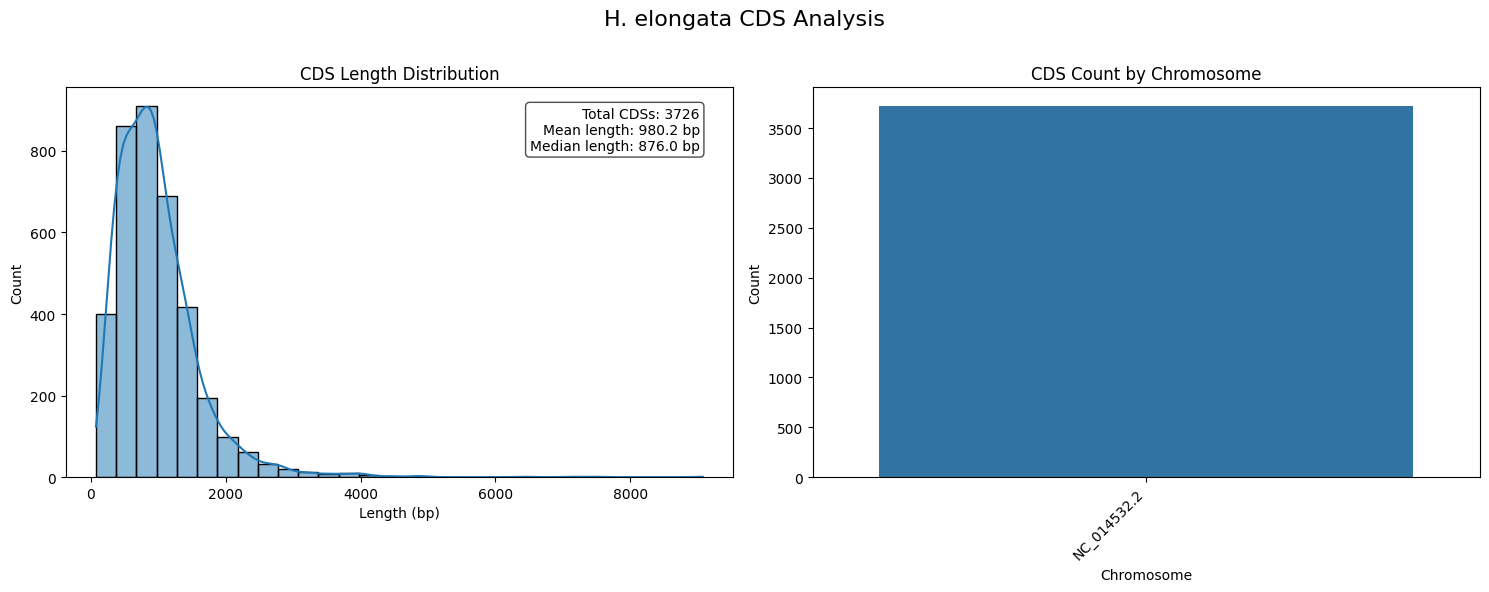

Saved CDS plot to output/report/cds_analysis.png

Processing overlap files...
Found 13 overlap files
  Processing YCZ4B8_13_m.S.00215.overlaps.bed...
  Processing YCZ4B8_1_m.S.00167.overlaps.bed...
  Processing YCZ4B8_17_m.S.00231.overlaps.bed...
    Saved to output/report/YCZ4B8_17_m.S.00231.overlaps_overlaps.csv
    Found 71 CDS overlaps
    Unique reads: 32
    Unique products: 4
    Plot saved to output/report/YCZ4B8_17_m.S.00231.overlaps_summary.png
  Processing YCZ4B8_9_m.S.00199.overlaps.bed...
    Saved to output/report/YCZ4B8_9_m.S.00199.overlaps_overlaps.csv
    Found 14 CDS overlaps
    Unique reads: 7
    Unique products: 4
    Plot saved to output/report/YCZ4B8_9_m.S.00199.overlaps_summary.png
  Processing YCZ4B8_11_m.S.00207.overlaps.bed...
    Saved to output/report/YCZ4B8_11_m.S.00207.overlaps_overlaps.csv
    Found 32 CDS overlaps
    Unique reads: 14
    Unique products: 2
    Plot saved to output/report/YCZ4B8_11_m.S.00207.overlaps_summary.png
  Processing YCZ4B8_14_

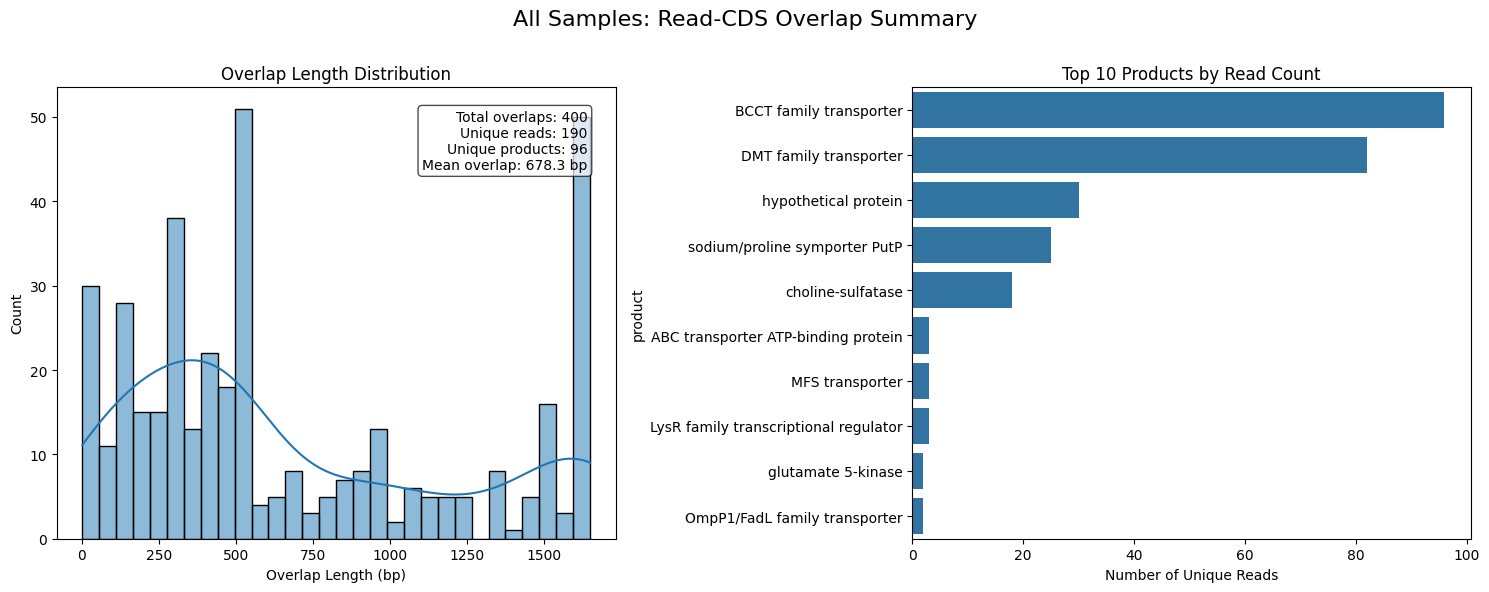

Saved combined plot to output/report/all_overlaps_summary.png


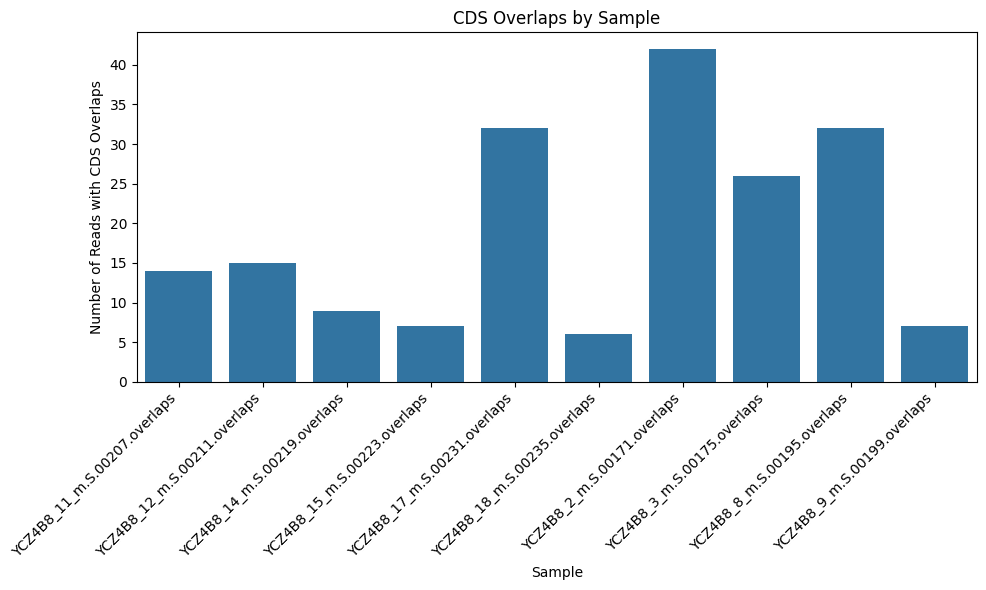

Saved sample comparison to output/report/sample_comparison.png

Analysis complete! All outputs saved to {report_dir}


In [11]:
# Import necessary libraries
import pandas as pd
import gffutils
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tempfile
import os
import warnings
warnings.filterwarnings('ignore')

# Create output directory
report_dir = Path('output/report')
report_dir.mkdir(exist_ok=True, parents=True)

# Process a GFF file to extract CDS features
def process_gff_file(gff_file):
    """Extract CDS features from a GFF file"""
    # Convert Path to string to avoid iteration issues
    gff_str = str(gff_file)
    db_path = tempfile.mktemp()
    
    try:
        # Parse GFF file
        db = gffutils.create_db(
            gff_str, 
            dbfn=db_path,
            force=True,
            keep_order=True,
            merge_strategy='merge'
        )
        
        # Extract CDS features
        cds_records = []
        for feature in db.features_of_type('CDS'):
            attrs = feature.attributes
            
            # Get product name
            product = attrs.get('product', [''])[0] if 'product' in attrs else ''
            if not product and 'locus_tag' in attrs:
                product = attrs.get('locus_tag', [''])[0]
                
            # Create record
            record = {
                'seqid': feature.seqid,
                'start': feature.start,
                'end': feature.end,
                'strand': feature.strand,
                'length': feature.end - feature.start + 1,
                'product': product
            }
            cds_records.append(record)
        
        # Convert to DataFrame
        cds_df = pd.DataFrame(cds_records)
        
    finally:
        # Clean up
        if os.path.exists(db_path):
            os.remove(db_path)
    
    return cds_df

# Process bedtools intersect output
def process_overlap_file(overlap_file):
    """Process bedtools overlap file"""
    # Define columns
    cols = ['chrom', 'start', 'end', 'read_name', 'score', 'strand', 
            'thick_start', 'thick_end', 'rgb', 'blocks', 'block_sizes', 'block_starts',
            'gff_chrom', 'gff_source', 'gff_type', 'gff_start', 'gff_end', 
            'gff_score', 'gff_strand', 'gff_phase', 'gff_attributes', 'overlap_bp']
    
    # Read file
    try:
        df = pd.read_csv(overlap_file, sep='\t', names=cols)
        
        # Filter for CDS
        cds_df = df[df['gff_type'] == 'CDS'].copy()
        
        # Extract product from attributes
        def get_product(attr_str):
            for attr in attr_str.split(';'):
                if attr.startswith('product='):
                    return attr.replace('product=', '')
            return ''
        
        cds_df['product'] = cds_df['gff_attributes'].apply(get_product)
        
        # Simplify dataframe
        result = cds_df[['read_name', 'chrom', 'start', 'end', 'strand',
                        'gff_start', 'gff_end', 'gff_strand', 'product', 'overlap_bp']]
        
        return result
    except Exception as e:
        print(f"Error processing {overlap_file}: {e}")
        return pd.DataFrame()

# Plot CDS distribution
def plot_cds_features(cds_df, title="CDS Features"):
    """Plot CDS feature distribution"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Length distribution
    sns.histplot(cds_df['length'], bins=30, kde=True, ax=ax1)
    ax1.set_title('CDS Length Distribution')
    ax1.set_xlabel('Length (bp)')
    ax1.set_ylabel('Count')
    
    # Stats text
    stats = f"Total CDSs: {len(cds_df)}\n"
    stats += f"Mean length: {cds_df['length'].mean():.1f} bp\n"
    stats += f"Median length: {cds_df['length'].median():.1f} bp"
    ax1.text(0.95, 0.95, stats, transform=ax1.transAxes, 
             va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    # CDS per chromosome
    chr_counts = cds_df['seqid'].value_counts().head(10)
    sns.barplot(x=chr_counts.index, y=chr_counts.values, ax=ax2)
    ax2.set_title('CDS Count by Chromosome')
    ax2.set_xlabel('Chromosome')
    ax2.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    
    return fig

# Plot overlap summary
def plot_overlap_summary(overlap_df, title="Read-CDS Overlap Summary"):
    """Plot summary of read-CDS overlaps"""
    if overlap_df.empty:
        print("No overlap data to plot")
        return None
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Overlap length distribution
    sns.histplot(overlap_df['overlap_bp'], bins=30, kde=True, ax=ax1)
    ax1.set_title('Overlap Length Distribution')
    ax1.set_xlabel('Overlap Length (bp)')
    ax1.set_ylabel('Count')
    
    # Stats for overlap
    stats = f"Total overlaps: {len(overlap_df)}\n"
    stats += f"Unique reads: {overlap_df['read_name'].nunique()}\n"
    stats += f"Unique products: {overlap_df['product'].nunique()}\n"
    stats += f"Mean overlap: {overlap_df['overlap_bp'].mean():.1f} bp"
    ax1.text(0.95, 0.95, stats, transform=ax1.transAxes, 
             va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    # Top products
    product_counts = overlap_df.groupby('product')['read_name'].nunique().sort_values(ascending=False).head(10)
    sns.barplot(x=product_counts.values, y=product_counts.index, ax=ax2)
    ax2.set_title('Top 10 Products by Read Count')
    ax2.set_xlabel('Number of Unique Reads')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    
    return fig

# Process the specific GFF file
print("Processing GFF file...")
gff_file = 'refs/GCF_000196875.2/genomic.gff'
cds_df = process_gff_file(gff_file)

# Save CDS dataframe to the report directory
cds_csv_path = report_dir / 'genomic_cds.csv'
cds_df.to_csv(cds_csv_path, index=False)
print(f"Found {len(cds_df)} CDS features")
print(f"Saved CDS data to {cds_csv_path}")

# Plot CDS features and save to the report directory
fig = plot_cds_features(cds_df, title="H. elongata CDS Analysis")
cds_plot_path = report_dir / 'cds_analysis.png'
fig.savefig(cds_plot_path, dpi=300)
plt.show()
print(f"Saved CDS plot to {cds_plot_path}")

# Process overlap files
print("\nProcessing overlap files...")
overlap_dir = Path('output/overlaps')
overlap_files = list(overlap_dir.glob('*.bed'))
print(f"Found {len(overlap_files)} overlap files")

# Create a summary dataframe for all overlaps
all_overlaps = pd.DataFrame()

for overlap_file in overlap_files:
    print(f"  Processing {overlap_file.name}...")
    overlap_df = process_overlap_file(overlap_file)
    
    if not overlap_df.empty:
        # Add sample ID
        overlap_df['sample'] = overlap_file.stem
        
        # Save individual sample results to report directory
        sample_csv_path = report_dir / f"{overlap_file.stem}_overlaps.csv"
        overlap_df.to_csv(sample_csv_path, index=False)
        print(f"    Saved to {sample_csv_path}")
        
        # Append to all overlaps
        all_overlaps = pd.concat([all_overlaps, overlap_df])
        
        # Basic stats
        print(f"    Found {len(overlap_df)} CDS overlaps")
        print(f"    Unique reads: {overlap_df['read_name'].nunique()}")
        print(f"    Unique products: {overlap_df['product'].nunique()}")
        
        # Plot individual sample summary
        fig = plot_overlap_summary(overlap_df, title=f"{overlap_file.stem}: Read-CDS Overlap Summary")
        sample_plot_path = report_dir / f"{overlap_file.stem}_summary.png"
        fig.savefig(sample_plot_path, dpi=300)
        plt.close(fig)  # Close to avoid showing every individual plot
        print(f"    Plot saved to {sample_plot_path}")

# Save all overlaps
if not all_overlaps.empty:
    all_overlaps_csv = report_dir / 'all_overlaps.csv'
    all_overlaps.to_csv(all_overlaps_csv, index=False)
    print(f"Saved combined overlaps to {all_overlaps_csv}")
    
    # Plot overall summary
    fig = plot_overlap_summary(all_overlaps, title="All Samples: Read-CDS Overlap Summary")
    all_plot_path = report_dir / 'all_overlaps_summary.png'
    fig.savefig(all_plot_path, dpi=300)
    plt.show()
    print(f"Saved combined plot to {all_plot_path}")
    
    # Sample comparison (if multiple samples)
    if all_overlaps['sample'].nunique() > 1:
        plt.figure(figsize=(10, 6))
        sample_counts = all_overlaps.groupby('sample')['read_name'].nunique()
        sns.barplot(x=sample_counts.index, y=sample_counts.values)
        plt.title('CDS Overlaps by Sample')
        plt.xlabel('Sample')
        plt.ylabel('Number of Reads with CDS Overlaps')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        comparison_path = report_dir / 'sample_comparison.png'
        plt.savefig(comparison_path, dpi=300)
        plt.show()
        print(f"Saved sample comparison to {comparison_path}")

print("\nAnalysis complete! All outputs saved to {report_dir}")